# Parsing and visualizing the AHRF (Area Health Resource File)


This I-Python Notebook explores the AHRF (Area Health Resource File) data set available for download from the [HRSA (Health Resources and Service Administration)](http://ahrf.hrsa.gov/) website. You can download the source code and the API to parse the AHRF [here](https://github.com/adityanagara/AHRF_project). You can download the date from the link provided previously or use the following command to download and unzip the data to the same folder in which this I-Python notebook resides and follow along.

In [1]:
!wget https://datawarehouse.hrsa.gov/DataDownload/AHRF/AHRF_2015-2016.zip
!unzip AHRF_2015-2016.zip -o

--2017-01-07 10:38:00--  https://datawarehouse.hrsa.gov/DataDownload/AHRF/AHRF_2015-2016.zip
Resolving datawarehouse.hrsa.gov (datawarehouse.hrsa.gov)... 162.99.248.241, 2607:f220:41c:400::f10
Connecting to datawarehouse.hrsa.gov (datawarehouse.hrsa.gov)|162.99.248.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24370231 (23M) [application/x-zip-compressed]
Saving to: ‘AHRF_2015-2016.zip.2’

AHRF_2015-2016.zip. 100%[=====================>]  23.24M  1.15MB/s   in 24s    

2017-01-07 10:38:25 (983 KB/s) - ‘AHRF_2015-2016.zip.2’ saved [24370231/24370231]

Archive:  AHRF_2015-2016.zip
caution: filename not matched:  -o


## Introduction 
The county level AHRF contains 3230 records and 6920 variables. These variables include data on health care providers, health care facilities, health care facilities utilization, expenditures and demographic information at the county level. To optimize for speed, the API uses the multiprocessing module to parse the ASCII file. The API allows the user to select a set of variables to extract from the ASCII file and load it as a Pandas data frame. The description of the variables is given in the technical documentation which comes along with the zip file on downloading the data. The .sas file is used to obtain the variable names and locations of the variables on the ASCII file. A meta_data.csv is created as a look up table for variable name and location on the ASCII file once you call the object parse_AHRF_ascii(). We analyze a small subset of these variables at the country, state and county levels and discuss some correlations between these variables. 

In [2]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns 
%matplotlib inline
import AHRF_parser;reload(AHRF_parser)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

/Users/adityanagarajan/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Country Level Analysis
Let us begin by loading all of our variables as a Pandas data frame and look at the country averages of these variables over time. 

In [3]:
# Takes as input number of cores to use
ahrf_parser = AHRF_parser.parse_AHRF_ascii(num_cores = 8,
                                           ascii_file_path = "DATA/ahrf2016.asc",
                                           sas_file_path="DOC/ahrf2015-16.sas")
# Determine a set of medical care providers variables to analyze
medical_providers_columns = ["Header-FIPSStandCtyCode","FIPSStateCode",
                              "FIPSCountyCode",
                              "StateNameAbbreviation",
                               "CountyName"]

medical_providers_columns.extend(["CensusPopulation2010"])
medical_providers_columns.extend(["PopulationEstimate201{}".format(x) for x in range(1,5)])
medical_providers_columns.extend(["Phys,PrimaryCare,PatientCareNon-Fed201{}".format(x) for x in range(5)])
medical_providers_columns.extend(["TotalActiveM.D.sNon-FederalNon-Fed201{}".format(x) for x in range(5)])
medical_providers_columns.extend(["TotalActiveD.O.sNon-FederalNon-Fed201{}".format(x) for x in range(5)])

all_columns = medical_providers_columns

meta data file exists loading...


In [4]:
# Determine a set of medical expenditures variables to analyze
expenditures_columns = []
expenditures_columns.extend(["TotalActualMedicareCostsFeeforService201{}".format(x) for x in range(5)])
expenditures_columns.extend(["TotStandardizedMedicareCostsFeeforService201{}".format(x) for x in range(5)])
expenditures_columns.extend(["ActualPerCapitaMedicareCostFeeforService201{}".format(x) for x in range(5)])
expenditures_columns.extend(["StandardzdPerCapitaMedcrCostFeeforService201{}".format(x) for x in range(5)])
expenditures_columns.extend(["MedcreBenefHospReadmissRateFeeforService201{}".format(x) for x in range(5)])
all_columns.extend(expenditures_columns)

In [5]:
# Determine a set of medical facilities utilization variables to analyze
utilization_columns = []
utilization_columns.extend(["HospitalBeds2013",
                            "ShortTermGeneralHospBeds2013",
                            "InpatientDaysinSTGenHosp2013",
                            "TotalNumberHospitals2013",
                            "#ShortTermGeneralHosps2013",
                            "HospitalAdmissions2013",
                            "ShortTermGenHospAdmissions2013",
                            "TotalMedicareInpatientDaysShortTermGeneralHospitals2013",
                            "DistHospBy00-39%UtilRateShortTermGeneralHospitals2013",
                            "DistHospBy40-59%UtilRateShortTermGeneralHospitals2013",
                            "DistHospBy60-79%UtilRateShortTermGeneralHospitals2013",
                            "DistHospBy80+%UtilRateShortTermGeneralHospitals2013"])
all_columns.extend(utilization_columns)

In [6]:
# Determine a set of demographics variables to analyze
demographics_columns = []
demographics_columns.extend(["%<65withoutHealthInsurance201{}".format(x) for x in range(5)])
demographics_columns.extend(["UnemploymentRate,16+201{}".format(x) for x in range(5)])
demographics_columns.extend(["PerCapitaPersonalIncome201{}".format(x) for x in range(5)])
demographics_columns.extend(["MedianHouseholdIncome201{}".format(x) for x in range(5)])
demographics_columns.extend(["PercentPersonsinPoverty201{}".format(x) for x in range(5)])
demographics_columns.extend(["Pers<65withoutHealthIns201{}".format(x) for x in range(5)])
all_columns.extend(demographics_columns)

ahrf_frame = ahrf_parser.parse_ahrf_file_multicore(ahrf_columns = all_columns)
ahrf_frame.shape

Loading variables to a DataFrame...
[slice(0, 403, None), slice(403, 806, None), slice(806, 1209, None), slice(1209, 1612, None), slice(1612, 2015, None), slice(2015, 2418, None), slice(2418, 2821, None), slice(2821, None, None)]
Data frame saved at DATA/ahrf_data.csv
Total time taken 251.2288 s


(3230, 92)

Let us define some helper functions that converts these the fields in the data frame to numerical fields. We also define a helper function to normalize a given variable by population. I chose the normalization by population as it gives a good estimate of density of resources as available to N people, the default value is N = 100000, but can be set as a parameter to the function.

In [7]:
def convert_to_numeric(data_frame):
    '''This function takes in a DataFrame and converst the given 
    columns to numeric value with NaN for any string that is not 
    a number.
    input: data frame
    
    output: data frame with all numerical fields conveterd to numerical data types
    '''
    for col in list(data_frame.keys()):
        if col not in ["StateNameAbbreviation","FIPSStateCode","FIPSCountyCode","Header-FIPSStandCtyCode","CountyName"]:
            data_frame[col] = pd.to_numeric(data_frame[col],errors = "coerce")
    return data_frame

def normalize_by_population(data_frame,columns,population = 100000):
    '''Function which takes in a data frame and normalizes the variables for 100K people
    similar to http://ahrf.hrsa.gov/arfdashboard/ArfGeo.aspx
    
    Note: The data frame should contain the column for the population estimete for the corrosponding year
    input: data frame
    input: list of columns to normalize
    input: normalize by number of people
    
    output: input data frame with additional normalized columns
    '''
    for col in columns:
        year = re.findall('\d+',col)[0]
        data_frame[col + "PopNorm"] = (data_frame[col] / data_frame["PopulationEstimate" + year]) * population
    return data_frame

In [8]:
ahrf_frame = convert_to_numeric(ahrf_frame)

In [9]:
ahrf_frame = ahrf_frame.rename(columns = {"CensusPopulation2010" : "PopulationEstimate2010"})
# Remove Guam, Puerto Rico and US Virgin Islands
ahrf_frame = ahrf_frame[~ahrf_frame.FIPSStateCode.isin(["66","72","78"])]

In [10]:
ahrf_frame.describe()

,PopulationEstimate2010,PopulationEstimate2011,PopulationEstimate2012,PopulationEstimate2013,PopulationEstimate2014,"Phys,PrimaryCare,PatientCareNon-Fed2010","Phys,PrimaryCare,PatientCareNon-Fed2011","Phys,PrimaryCare,PatientCareNon-Fed2012","Phys,PrimaryCare,PatientCareNon-Fed2013","Phys,PrimaryCare,PatientCareNon-Fed2014",...,PercentPersonsinPoverty2010,PercentPersonsinPoverty2011,PercentPersonsinPoverty2012,PercentPersonsinPoverty2013,PercentPersonsinPoverty2014,Pers<65withoutHealthIns2010,Pers<65withoutHealthIns2011,Pers<65withoutHealthIns2012,Pers<65withoutHealthIns2013,Pers<65withoutHealthIns2014
count,3143.00,3143.00,3143.00,3143.00,3142.00,3143.00,3143.00,3143.00,3143.00,3142.00,...,3142.00,3142.00,3142.00,3142.00,3141.00,3142.00,3142.00,3142.00,3142.00,3141.00
mean,98232.75,99138.38,99877.20,100581.88,101482.19,71.81,73.17,74.41,76.20,76.77,...,16.76,17.24,17.20,17.22,16.84,14817.57,14553.01,14309.37,14155.94,11465.77
std,312901.20,316399.80,319578.63,322331.63,326174.16,249.28,254.54,259.57,266.49,268.32,...,6.24,6.50,6.58,6.60,6.46,62033.29,60351.38,59731.22,58718.33,46158.22
min,82.00,90.00,71.00,90.00,86.00,0.00,0.00,0.00,0.00,0.00,...,3.10,2.90,3.10,3.00,3.20,18.00,17.00,13.00,16.00,13.00
25%,11104.50,11062.00,11006.50,11012.50,11028.25,4.00,4.00,4.00,4.00,4.00,...,12.30,12.50,12.40,12.50,12.10,1635.25,1574.25,1505.00,1508.25,1204.00
50%,25857.00,25874.00,25827.00,25726.00,25714.50,12.00,12.00,12.00,12.00,12.00,...,15.90,16.50,16.30,16.30,15.80,3793.00,3686.50,3597.50,3547.00,2884.00
75%,66699.00,67132.50,67260.00,67463.00,67762.25,39.00,39.00,39.00,40.00,40.00,...,20.20,20.70,20.90,20.90,20.40,9547.00,9292.00,9071.50,8998.25,7290.00
max,9818605.00,9889056.00,9962789.00,10017068.00,10116705.00,6947.00,7056.00,7174.00,7291.00,7297.00,...,50.10,49.90,51.20,55.10,52.20,2248384.00,2158922.00,2138687.00,2059406.00,1518890.00


Let us take a look at the changes in medical care providers over time from 2010 to 2014.

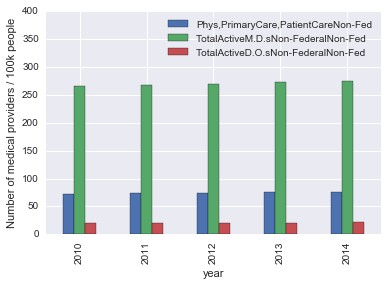

In [11]:
# Define a list of years we want to plot
years = ["201{}".format(x) for x in range(5)]
# define a data frame with that holds the year wise variables
medical_provider_summary_frame = pd.DataFrame(columns = ["year",
                                                         "PopulationEstimate",
                                                         "Phys,PrimaryCare,PatientCareNon-Fed",
                                                         "TotalActiveM.D.sNon-FederalNon-Fed",
                                                         "TotalActiveD.O.sNon-FederalNon-Fed"])
# Compute the total number of each variable
for i,yr in enumerate(years):
    medical_provider_summary_frame.loc[i,:] = [yr,
                                               ahrf_frame["PopulationEstimate" + yr].sum(),
                                               ahrf_frame["Phys,PrimaryCare,PatientCareNon-Fed" + yr].sum(),
                                               ahrf_frame["TotalActiveM.D.sNon-FederalNon-Fed" + yr].sum(),
                                               ahrf_frame["TotalActiveD.O.sNon-FederalNon-Fed" + yr].sum()]

# Normalize for 100k people
medical_provider_summary_frame_normalized = medical_provider_summary_frame[medical_provider_summary_frame.columns[2:]].apply(
                                                            lambda x : (x / medical_provider_summary_frame["PopulationEstimate"]) * 100000)

medical_provider_summary_frame_normalized["year"] = years
plot = medical_provider_summary_frame_normalized.plot.bar(x = "year",ylim = (0.0,400.0))
plot.set_ylabel("Number of medical providers / 100k people")

From the above bar plot we can see the number of medical providers (primary care physicians, MDs and DOs) per 100k people have not changed very much. The values are also printed in the following table. 

In [12]:
medical_provider_summary_frame_normalized

,"Phys,PrimaryCare,PatientCareNon-Fed",TotalActiveM.D.sNon-FederalNon-Fed,TotalActiveD.O.sNon-FederalNon-Fed,year
0,73.10,266.42,19.38,2010
1,73.81,267.55,19.57,2011
2,74.50,270.13,20.23,2012
3,75.76,272.81,20.90,2013
4,75.65,274.73,21.60,2014


In [13]:
def get_5year_means(data_frame,columns):
    """
    Function that computes a variable over time from 2010 - 2014
    
    input: data frame containing all columns (data fields must be from 2010-2014)
    input: list of columns to generate the time series
    
    output: a data frame with year and means of each variable (year as rows and variable as columns)
    """
    summary = pd.DataFrame(columns = columns)
    years = ["201{}".format(x) for x in range(5)]
    for i,yr in enumerate(years):
        temp = [yr]
        temp.extend(map(lambda x: data_frame[x + yr].mean(),columns[1:]))
        summary.loc[i,columns] = temp
    return summary

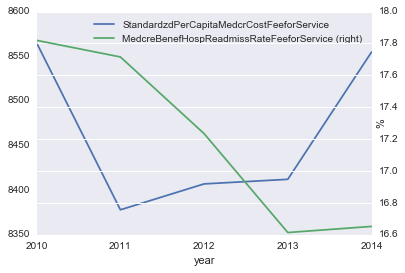

In [14]:
expenditures_summary = get_5year_means(ahrf_frame,["year",
                                                   "StandardzdPerCapitaMedcrCostFeeforService",
                                                   "MedcreBenefHospReadmissRateFeeforService"])
plot = expenditures_summary.plot(x = "year",y=["StandardzdPerCapitaMedcrCostFeeforService",
                                        "MedcreBenefHospReadmissRateFeeforService"],
                          secondary_y=["MedcreBenefHospReadmissRateFeeforService"])

plot.set_ylabel("cost")
plot.yaxis.set_label_position("right")
plot.set_ylabel("%")

From the above plot we see that the national average Medicare cost has seen a sharp increase from the year 2013 to 2014. We also notice that readmissions rate which is defined as "Medicare Beneficiary FFS Acute Hospital Readmission is the total count of inpatient readmissions within 30 days" decreases from 2010 to 2013 but increases from the year 2013 to 2014. This may suggest that some of the Medicare costs may be due to this increase in readmissions rate. We next look at the change in demographic data over time from 2010 to 2014.

In [15]:
demographics_summary = get_5year_means(ahrf_frame,["year",
                                                   "UnemploymentRate,16+",
                                                   "%<65withoutHealthInsurance",
                                                   "PercentPersonsinPoverty",
                                                   "MedianHouseholdIncome",
                                                   "PerCapitaPersonalIncome"])

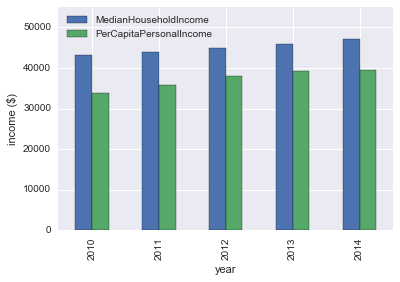

In [16]:
plot = demographics_summary.plot.bar(x = "year",y = ["MedianHouseholdIncome","PerCapitaPersonalIncome"],ylim = (0,55000))
plot.set_ylabel("income ($)")

We can see from the above plot that there is a gradual increase in average per-capita and median household income. 

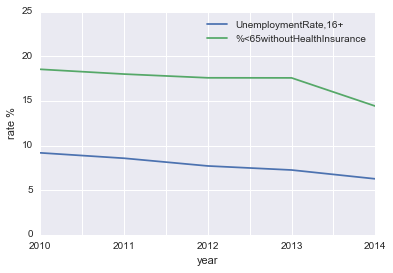

In [17]:
plot = demographics_summary.plot(x="year",y=["UnemploymentRate,16+","%<65withoutHealthInsurance"],ylim = (0.0,25.0))
plot.set_ylabel("rate %")

The above plot shows the average unemployment rate and percentage of people without health insurance decrease over the years of 2010-2014. There is a large decrease in percentage of people without health insurance from the year 2013 to 2014. Unemployment rate is defined for people over 16 years of age and percentage of people without health insurance is defined for people less than 65 years of age. From here on out when we refer to unemployment rate and percentage of people without health insurance this is what we mean.

The significant drop in percentage of people without health insurance seems to be the result of result of Obama care cited in [this](http://obamacarefacts.com/whatis-obamacare/) article. 

In [18]:
demographics_summary

,year,"UnemploymentRate,16+",%<65withoutHealthInsurance,PercentPersonsinPoverty,MedianHouseholdIncome,PerCapitaPersonalIncome
0,2010,9.18,18.54,16.76,43144.87,33777.77
1,2011,8.57,18.00,17.24,43870.53,35703.89
2,2012,7.71,17.58,17.20,44834.99,37968.07
3,2013,7.26,17.58,17.22,46008.22,39199.80
4,2014,6.27,14.42,16.84,47124.83,39519.68


The above table which shows the national average for each variable and each year suggests that although unemployment has decreased poverty rates have largely remained the same.
## State Level Analysis
### Medical Providers
Let us start by aggregating the population, total active MDs, primary care physicians and total active DOs for each state in the year 2014 and normalize the primary care physicians for 100k people.

In [19]:
state_wise_medical_provider = ahrf_frame.groupby(["StateNameAbbreviation"],as_index=False)["PopulationEstimate2014",
                                                                             "TotalActiveM.D.sNon-FederalNon-Fed2014",
                                                                            "TotalActiveD.O.sNon-FederalNon-Fed2014",
                                                                            "Phys,PrimaryCare,PatientCareNon-Fed2014"].sum()

state_wise_medical_provider = normalize_by_population(state_wise_medical_provider,["Phys,PrimaryCare,PatientCareNon-Fed2014"])

The data is sorted by primary care physician densities with the following two tables showing the states with the highest and lowest primary care physician densities. 

In [20]:
state_wise_medical_provider.sort_values(by = "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",ascending = 0)[:5][["StateNameAbbreviation",
                                                                                                 "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"]]

,StateNameAbbreviation,"Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"
7,DC,113.37
46,VT,111.88
21,ME,110.52
19,MA,105.21
39,RI,96.19


In [21]:
state_wise_medical_provider.sort_values(by = "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",ascending = 0)[-5:][["StateNameAbbreviation",
                                                                                                 "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"]]

,StateNameAbbreviation,"Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"
13,ID,64.12
43,TX,59.82
44,UT,57.46
33,NV,57.17
25,MS,52.74


From the first table above the state with the highest primary care physician density is Washington D.C with 113 physicians for every 100k people and the lowest density is Missouri with 53 physicians for 100k people. To plot the distribution of the primary care physician density across USA we write the following helper function. This function can be used to plot any variable along with displaying other variables as we hover over each state. We make use of the [Bokeh](http://bokeh.pydata.org/en/latest/) API in Python.

In [22]:
from bokeh.sampledata import us_states, us_counties
from bokeh.plotting import figure, show, output_notebook
from bokeh import palettes
from bokeh.models import ColorBar,HoverTool,LinearColorMapper,ColumnDataSource,FixedTicker
output_notebook()

def plot_us_map(state_wise,variable_to_distribute,variables_to_display):
    """plots the distribution of a given variable across the CONUS
    input: state_wise is the input data frame containing all of the data grouped by each state
    input: variable_to_distribute is the variable that needs to be plotted across CONUS
    input: variables_to_display is the list of variables to display while hovering over each state
    
    output: Bokeh plotting object which cab be user to plot by using show(p)
    """
    us_states_ = us_states.data.copy()
    if variable_to_distribute in variables_to_display:
        variables_to_display.remove(variable_to_distribute)

    del us_states_["HI"]
    del us_states_["AK"]
    colors = palettes.viridis(5)

    state_xs = [us_states_[code]["lons"] for code in us_states_]
    state_ys = [us_states_[code]["lats"] for code in us_states_]

    min_value = round(state_wise[variable_to_distribute].min(),2)
    max_value = round(state_wise[variable_to_distribute].max(),2)
    
    gran = (max_value - min_value) / float(len(colors))
    index_range = [min_value + x*gran for x in range(len(colors))]
    
    state_colors = []
    states = []
    variable_dictionary = {}
    variable_dictionary["x"] = state_xs
    variable_dictionary["y"] = state_ys
    variable_dictionary[re.sub("[^\w]","",variable_to_distribute)] = []
    
    for vd in variables_to_display:
        variable_dictionary[re.sub("[^\w]","",vd)] = []
    for code in us_states_:
        states.append(code)
        temp_var = round(float(state_wise[state_wise["StateNameAbbreviation"] == code][variable_to_distribute].values),2)
        color_idx = list(temp_var - np.array(index_range)).index(min(x for x in list(temp_var - np.array(index_range)) if x >= 0))
        state_colors.append(colors[color_idx])
        #state_colors.append(colors[np.argmin(np.abs(np.array(index_range) - temp_var))])
        variable_dictionary[re.sub("[^\w]","",variable_to_distribute)].append(temp_var)
        for vd in variables_to_display:
            variable_dictionary[re.sub("[^\w]","",vd)].append(round(float(state_wise[state_wise["StateNameAbbreviation"] == code][vd].values),2))
            
    variable_dictionary["state_name"] = states
    variable_dictionary["color"] = state_colors
    source = ColumnDataSource(data = variable_dictionary)
    mapper = LinearColorMapper(palette=colors, low=min_value, high=max_value)

    color_bar = ColorBar(color_mapper=mapper, location=(0, 0), orientation='horizontal', 
                     title = variable_to_distribute,ticker=FixedTicker(ticks=index_range))

    TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"
    p = figure(title=variable_to_distribute, toolbar_location="left",tools=TOOLS,
        plot_width=1100, plot_height=700,x_axis_location=None, y_axis_location=None)

    p.patches('x', 'y', source=source, fill_alpha=0.7,fill_color='color',
        line_color="#884444", line_width=2)

    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    tool_tips = [("State ", "@state_name")]
    for key in variable_dictionary.keys():
        if key not in ["x","y","color","state_name"]:
            tool_tips.append((key,"@"+re.sub("[^\w]","",key) + "{1.11}"))
    hover.tooltips = tool_tips
    p.add_layout(color_bar, 'below')

    return p

Loading BokehJS ...

We write a function to normalize a given field by state wise or country wise average and standard deviation. This will be useful to query the data about things like what is the proportion of states that have above average readmission rates given that they have above average per-capita Medicare cost. 

In [23]:
def normalize_country_state(data_frame, country_state = "country",variables = ["Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"]):
    """Function that centers the data at 0 based on the country average or state average (subtracts the mean and divides by standard deviation)
    
    input: data frame consisting of all the columns
    country_state: {"country","state"} Normalize by wither country average or state average for each county
    variables: list of variables to normalize
    
    output: the input data_frame with additional columns with the normalized data 
    output: A dictionary containing the country or state mean and standard deviations
    """
    if country_state == "country":
        vatiable_stats = {}
        for var in variables:
            vatiable_stats[var + "_mean"] = data_frame[var].mean()
            vatiable_stats[var + "_std"] = data_frame[var].std()
            data_frame[var + "CountryNorm"] = (data_frame[var] - vatiable_stats[var + "_mean"]) / vatiable_stats[var + "_std"]
    elif country_state == "state":
        vatiable_stats = {}
        for var in variables:
            data_frame.ix[:,var + "StateNorm"] = 0
            for st in data_frame["StateNameAbbreviation"].unique():
                if st != "DC":
                    vatiable_stats[var + "StateNorm_mean" + st] = data_frame[data_frame["StateNameAbbreviation"] == st][var].mean()
                    vatiable_stats[var + "StateNorm_std" + st] = data_frame[data_frame["StateNameAbbreviation"] == st][var].std()
                    data_frame.ix[data_frame["StateNameAbbreviation"] == st,var + "StateNorm"] = (data_frame[data_frame["StateNameAbbreviation"] == st][var] - 
                                                                                                   vatiable_stats[var + "StateNorm_mean" + st]) / vatiable_stats[var + "StateNorm_std" + st]
                else:
                    vatiable_stats[var + "StateNorm_mean" + st] = data_frame[data_frame["StateNameAbbreviation"] == st][var].mean()
                    vatiable_stats[var + "StateNorm_std" + st] = 0.0
                    data_frame.ix[data_frame["StateNameAbbreviation"] == st,var + "StateNorm"] = 0.0
    return data_frame,vatiable_stats

In [24]:
state_wise_medical_provider,stats = normalize_country_state(state_wise_medical_provider,"country",variables=["Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"])

Let us plot the the distribution of primary care physicians normalized by population and national average and standard deviation. We thus get values that are certain standard deviations above and below the mean. The user can choose which variable to plot the distribution on and which variables to display as we hover over each state. 

In [25]:
p = plot_us_map(state_wise_medical_provider,
                "Phys,PrimaryCare,PatientCareNon-Fed2014PopNormCountryNorm",
               ["TotalActiveM.D.sNon-FederalNon-Fed2014",
                "TotalActiveD.O.sNon-FederalNon-Fed2014",
                "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",
                "Phys,PrimaryCare,PatientCareNon-Fed2014PopNormCountryNorm"])

print "The Country mean of %s is %.2f and the standard deviation is %.2f"%("Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",
                                                                     stats["Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm" + "_mean"],
                                                                    stats["Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm" + "_std"])

show(p)

The Country mean of Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm is 77.77 and the standard deviation is 13.70


You can hover over each state to see more information such as total active MDs and DOs. The above plot shows the distribution of primary care physicians for every 100k population across the US normalized by the national average and standard deviation. It is interesting to see that the New-England states along with Washington D.C has the highest density of active primary care physicians in the entire country.
### Medical Expenditures
Let us look into the average per-capita Medicare cost and readmission rates for each state. The mean for each state is computed and sorted on per-capita Medicare costs. The following two tables show the top 5 and bottom 5 states with regard to their per-capita Medicare cost.

In [26]:
state_wise_expenditures_summary = ahrf_frame.groupby(["StateNameAbbreviation"],as_index=False)["StandardzdPerCapitaMedcrCostFeeforService2014",
                                                                                                "ActualPerCapitaMedicareCostFeeforService2014",
                                                                                                "TotStandardizedMedicareCostsFeeforService2014",
                                                                                                "TotalActualMedicareCostsFeeforService2014",
                                                                                                "MedcreBenefHospReadmissRateFeeforService2014"].mean()

state_wise_expenditures_summary.sort_values(by = "StandardzdPerCapitaMedcrCostFeeforService2014",ascending=0)[:5][["StateNameAbbreviation",
                                                                                                              "StandardzdPerCapitaMedcrCostFeeforService2014",
                                                                                                              "MedcreBenefHospReadmissRateFeeforService2014"]]


,StateNameAbbreviation,StandardzdPerCapitaMedcrCostFeeforService2014,MedcreBenefHospReadmissRateFeeforService2014
18,LA,10950.21,18.15
25,MS,10217.35,18.03
43,TX,10115.39,16.42
9,FL,10056.90,18.91
31,NJ,9536.96,19.02


In [27]:
state_wise_expenditures_summary.sort_values(by = "StandardzdPerCapitaMedcrCostFeeforService2014",ascending=0)[-5:][["StateNameAbbreviation",
                                                                                                              "StandardzdPerCapitaMedcrCostFeeforService2014",
                                                                                                              "MedcreBenefHospReadmissRateFeeforService2014"]]

,StateNameAbbreviation,StandardzdPerCapitaMedcrCostFeeforService2014,MedcreBenefHospReadmissRateFeeforService2014
0,AK,6776.11,14.15
26,MT,6733.37,13.93
46,VT,6706.68,15.32
37,OR,6611.57,13.76
11,HI,5699.14,13.91


There is no surprise seeing Florida in the top 5 per-capita Medicare cost, which is known as a retirement destination. We cal also see that states which have a high per-capita Medicare cost also have a relatively larger readmissions rate. New Jersey has the highest readmissions rate from the states shown above, which suggests that much of the Medicare cost may be going towards readmissions. Let us determine the states in the US which have above average per-capita Medicare cost and above average readmissions rate. We define variable $X$ to represent per-capita Medicare cost and variable $Y$ to represent readmissions rate. We calculate the probability $P(Y > 0.0,X > 0.0)$ and $P(Y > 0.0 | X > 0.0)$, the latter probability estimate will give good understanding of the proportion of states with high Medicare cost as a result of high readmissions rate. We begin by normalizing the per-capita Medicare cost and the readmissions rate by the country average and standard deviation. 

In [28]:
state_wise_expenditures_summary,stats = normalize_country_state(state_wise_expenditures_summary,
                                                          "country",
                                                          ["StandardzdPerCapitaMedcrCostFeeforService2014",
                                                           "MedcreBenefHospReadmissRateFeeforService2014"])

In [29]:
p_x_and_y = state_wise_expenditures_summary[(state_wise_expenditures_summary["StandardzdPerCapitaMedcrCostFeeforService2014CountryNorm"] > 0.0) 
                                & (state_wise_expenditures_summary["MedcreBenefHospReadmissRateFeeforService2014CountryNorm"] > 0.0)]["StateNameAbbreviation"].count() / 51.0

p_y_given_x = state_wise_expenditures_summary[(state_wise_expenditures_summary["StandardzdPerCapitaMedcrCostFeeforService2014CountryNorm"] > 0.0) 
                                & (state_wise_expenditures_summary["MedcreBenefHospReadmissRateFeeforService2014CountryNorm"] > 0.0)]["StateNameAbbreviation"].count() / float(state_wise_expenditures_summary[state_wise_expenditures_summary["StandardzdPerCapitaMedcrCostFeeforService2014CountryNorm"] > 0.0]["StateNameAbbreviation"].count())
print "P(Y > 0.0,X > 0.0) = %.2f"%p_x_and_y
print "P(Y > 0.0 | X > 0.0) = %.2f"%p_y_given_x
state_wise_expenditures_summary[(state_wise_expenditures_summary["StandardzdPerCapitaMedcrCostFeeforService2014CountryNorm"] > 0.0) 
                                & (state_wise_expenditures_summary["MedcreBenefHospReadmissRateFeeforService2014CountryNorm"] > 0.0)][["StateNameAbbreviation"
                                                                                                                            ,"StandardzdPerCapitaMedcrCostFeeforService2014CountryNorm"]]                               



P(Y > 0.0,X > 0.0) = 0.41
P(Y > 0.0 | X > 0.0) = 0.78


,StateNameAbbreviation,StandardzdPerCapitaMedcrCostFeeforService2014CountryNorm
1,AL,0.79
2,AR,0.25
6,CT,0.67
7,DC,1.16
8,DE,0.77
9,FL,1.69
10,GA,0.78
14,IL,0.23
17,KY,0.50
18,LA,2.51


78% of the States which have higher than average per-capita Medicare cost also have above than average readmissions rate. There seems to be a lot of potential on focusing on reducing readmission rates to drive down per-capita Medicare cost. We next plot the distribution of standardized per capita Medicare cost fee for service across the US normalized by country mean and standard deviation. Here again the user can decide on which variable to plot the distribution across the US. 

In [30]:
p = plot_us_map(state_wise_expenditures_summary,
                "StandardzdPerCapitaMedcrCostFeeforService2014CountryNorm",
                ["ActualPerCapitaMedicareCostFeeforService2014",
                 "TotStandardizedMedicareCostsFeeforService2014",
                 "TotalActualMedicareCostsFeeforService2014",
                 "MedcreBenefHospReadmissRateFeeforService2014",
                 "StandardzdPerCapitaMedcrCostFeeforService2014",
                 "MedcreBenefHospReadmissRateFeeforService2014CountryNorm"])
print "The Country mean of %s is %.2f and the standard deviation is %.2f"%("StandardzdPerCapitaMedcrCostFeeforService2014CountryNorm",
                                                                     stats["StandardzdPerCapitaMedcrCostFeeforService2014" + "_mean"],
                                                                    stats["StandardzdPerCapitaMedcrCostFeeforService2014" + "_std"])
print "The Country mean of %s is %.2f and the standard deviation is %.2f"%("MedcreBenefHospReadmissRateFeeforService2014",
                                                                     stats["MedcreBenefHospReadmissRateFeeforService2014" + "_mean"],
                                                                    stats["MedcreBenefHospReadmissRateFeeforService2014" + "_std"])
show(p)

The Country mean of StandardzdPerCapitaMedcrCostFeeforService2014CountryNorm is 8232.67 and the standard deviation is 1081.14
The Country mean of MedcreBenefHospReadmissRateFeeforService2014 is 16.53 and the standard deviation is 1.88


States in the West generally seem to have lower standardized per capita Medicare costs than states in the east. Although Texas seems to have a high per-capita Medicare cost, the readmissions rate of 16.42 is still on par with the national average of 16.53. However New Jersey has a readmissions rate of 19.02% which is 1.21 standard deviations above normal indicating potential for reduction in per-capita Medicare cost by reducing readmission rates.

Washington DC, Florida, New Jersey and Louiasina are states where there is a lot of potential to reduce per-capita Medicare cost by reducing the readmissions rate. 
### Utilization 
Utilization data is not available for for the year 2014 and hence we look at data provided from 2013. The number of short term general hospitals and utilization rates are aggregated for each state and normalized for 100k people. The data is sorted on the number of hospitals for 100k people and the following is a plot of utilization divided into 4 categories i.e distribution of hospitals which are utilized 0-39%,30-59%,60-79%,80+% which is from mild utilization to heavy utilization of hospitals for states with the highest and lowest hospital densities.

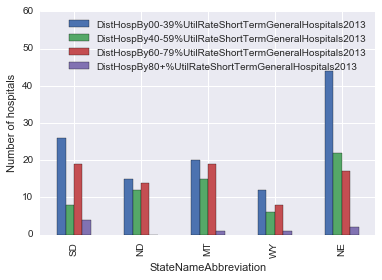

In [31]:
state_wise_utilization_summary = ahrf_frame.groupby(["StateNameAbbreviation"],as_index=False)["StateNameAbbreviation",
                                                                                              "PopulationEstimate2013",
                                                                                              "HospitalBeds2013",
                                                                                              "ShortTermGeneralHospBeds2013",
                                                                                              "InpatientDaysinSTGenHosp2013",
                                                                                              "#ShortTermGeneralHosps2013",
                                                                                              "DistHospBy00-39%UtilRateShortTermGeneralHospitals2013",
                                                                                              "DistHospBy40-59%UtilRateShortTermGeneralHospitals2013",
                                                                                              "DistHospBy60-79%UtilRateShortTermGeneralHospitals2013",
                                                                                              "DistHospBy80+%UtilRateShortTermGeneralHospitals2013"].sum()

state_wise_utilization_summary = normalize_by_population(state_wise_utilization_summary,["ShortTermGeneralHospBeds2013",
                                                                                         "#ShortTermGeneralHosps2013"
                                                                                         ])

plot = state_wise_utilization_summary.sort_values(by = "#ShortTermGeneralHosps2013PopNorm",
                                           ascending=0)[:5][["StateNameAbbreviation",
                                                             "#ShortTermGeneralHosps2013",
                                                             "#ShortTermGeneralHosps2013PopNorm",
                                                             "DistHospBy00-39%UtilRateShortTermGeneralHospitals2013",
                                                             "DistHospBy40-59%UtilRateShortTermGeneralHospitals2013",
                                                             "DistHospBy60-79%UtilRateShortTermGeneralHospitals2013",
                                                             "DistHospBy80+%UtilRateShortTermGeneralHospitals2013"]].plot.bar(x = "StateNameAbbreviation",
                                                                                                                              y=["DistHospBy00-39%UtilRateShortTermGeneralHospitals2013",
                                                                                                                                 "DistHospBy40-59%UtilRateShortTermGeneralHospitals2013",
                                                                                                                                 "DistHospBy60-79%UtilRateShortTermGeneralHospitals2013",
                                                                                                                                 "DistHospBy80+%UtilRateShortTermGeneralHospitals2013"],
                                                                                                                             stacked = False,ylim=(0.0,60.0))

plot.set_ylabel("Number of hospitals")

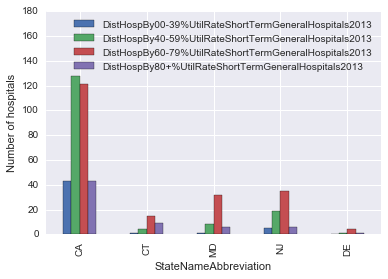

In [32]:
plot = state_wise_utilization_summary.sort_values(by = "#ShortTermGeneralHosps2013PopNorm",
                                           ascending=0)[-5:][["StateNameAbbreviation",
                                                             "#ShortTermGeneralHosps2013",
                                                             "#ShortTermGeneralHosps2013PopNorm",
                                                             "DistHospBy00-39%UtilRateShortTermGeneralHospitals2013",
                                                             "DistHospBy40-59%UtilRateShortTermGeneralHospitals2013",
                                                             "DistHospBy60-79%UtilRateShortTermGeneralHospitals2013",
                                                             "DistHospBy80+%UtilRateShortTermGeneralHospitals2013"]].plot.bar(x = "StateNameAbbreviation",
                                                                                                                              y=["DistHospBy00-39%UtilRateShortTermGeneralHospitals2013",
                                                                                                                                 "DistHospBy40-59%UtilRateShortTermGeneralHospitals2013",
                                                                                                                                 "DistHospBy60-79%UtilRateShortTermGeneralHospitals2013",
                                                                                                                                 "DistHospBy80+%UtilRateShortTermGeneralHospitals2013"],
                                                                                                                             stacked = False,ylim = (0.0,180.0))

plot.set_ylabel("Number of hospitals")

From the first plot above we can see that states with a high density of hospitals are generally under-utilized with tall blue bars indicating large proportions of hospitals utilized in the 0-39% ranges. From the bottom plot states with a high density of hospitals are generally more utilized with taller red bars indicating large proportions of the hospitals utilized in the 60-79% range.
### Demographics data
We look into demographic data such as unemployment rate, percentage of people without health insurance and per-capita income averaged for each state. The values are sorted on per-capita personal income and the following table shows the top 5 and bottom 5 states based on the average per-capita personal income.

In [33]:
state_wise_summary_demographics = ahrf_frame.groupby(["StateNameAbbreviation"],as_index=False)["%<65withoutHealthInsurance2014",
                                                                                                       "PerCapitaPersonalIncome2014",
                                                                                                       "UnemploymentRate,16+2014",
                                                                                                       "MedianHouseholdIncome2014",
                                                                                                       "PercentPersonsinPoverty2014"].mean()

state_wise_summary_demographics.sort_values(by = "PerCapitaPersonalIncome2014",ascending = 0)[:5][["StateNameAbbreviation",
                                                                                                   "PerCapitaPersonalIncome2014",
                                                                                                   "UnemploymentRate,16+2014",
                                                                                                   "MedianHouseholdIncome2014",
                                                                                                   "PercentPersonsinPoverty2014",
                                                                                                   "UnemploymentRate,16+2014"]]


,StateNameAbbreviation,PerCapitaPersonalIncome2014,"UnemploymentRate,16+2014",MedianHouseholdIncome2014,PercentPersonsinPoverty2014,"UnemploymentRate,16+2014"
7,DC,69838.00,7.80,69992.00,18.40,7.80
19,MA,57841.64,6.15,65328.64,11.62,6.15
6,CT,57450.50,6.43,70415.38,9.84,6.43
31,NJ,55827.62,7.05,72135.29,10.94,7.05
39,RI,54714.60,7.10,63471.00,11.10,7.10


In [34]:
state_wise_summary_demographics.sort_values(by = "PerCapitaPersonalIncome2014",ascending = 0)[-5:][["StateNameAbbreviation",
                                                                                                    "PerCapitaPersonalIncome2014",
                                                                                                    "UnemploymentRate,16+2014",
                                                                                                    "MedianHouseholdIncome2014",
                                                                                                    "PercentPersonsinPoverty2014",
                                                                                                    "UnemploymentRate,16+2014"]]

,StateNameAbbreviation,PerCapitaPersonalIncome2014,"UnemploymentRate,16+2014",MedianHouseholdIncome2014,PercentPersonsinPoverty2014,"UnemploymentRate,16+2014"
17,KY,32629.64,7.60,39687.22,21.85,7.60
40,SC,32607.17,7.59,40297.39,21.71,7.59
3,AZ,32366.07,9.62,43057.53,21.01,9.62
25,MS,31748.04,9.29,35659.48,25.40,9.29
10,GA,31542.51,8.13,41210.45,22.75,8.13


Next let us look into the distribution of percentage of people without health insurance across the US.

In [35]:
p = plot_us_map(state_wise_summary_demographics,"%<65withoutHealthInsurance2014",["PerCapitaPersonalIncome2014",
                                                                                  "UnemploymentRate,16+2014",
                                                                                  "MedianHouseholdIncome2014",
                                                                                  "PercentPersonsinPoverty2014"])
show(p)

Hovering over each state gives the per capita income, unemployment rate, percentage of people in poverty and median household income. It is interesting to note that there is no trend between unemployment rate and percentage of people without health insurance as one would expect. Massachusetts has 3.99% of people without insurance with an unemployment rate of 6.15 percent compared to Texas with 22.77% of people without health insurance and a 4.94 unemployment rate.
## County Level Analysis
### Medical Providers

In [36]:
ahrf_frame = normalize_by_population(ahrf_frame,["Phys,PrimaryCare,PatientCareNon-Fed2014"])

In [37]:
state_means = ahrf_frame.groupby(["StateNameAbbreviation"],as_index=False)["PopulationEstimate2014",
                                                                 "%<65withoutHealthInsurance2014",
                                                                 "UnemploymentRate,16+2014",
                                                                 "PerCapitaPersonalIncome2014",
                                                                 "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"].mean()

In [38]:
state_means.sort_values(by = "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",ascending=0)[:5][["StateNameAbbreviation",
                                                                                                "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"]]

,StateNameAbbreviation,"Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"
7,DC,113.37
39,RI,108.31
21,ME,98.13
30,NH,97.43
19,MA,96.02


In [39]:
state_means.sort_values(by = "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",ascending=0)[-5:][["StateNameAbbreviation",
                                                                                                "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"]]

,StateNameAbbreviation,"Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"
18,LA,42.15
36,OK,40.64
33,NV,40.44
25,MS,39.36
43,TX,38.13


Let us look into the distribution of primary care physicians density in states with the largest and lowest average primary care physicians density.

[[(<matplotlib.text.Text at 0x11f879550>,
   <matplotlib.text.Text at 0x120621510>),
  (<matplotlib.text.Text at 0x12017d190>,
   <matplotlib.text.Text at 0x12016a210>)],
 [(<matplotlib.text.Text at 0x11f879190>,
   <matplotlib.text.Text at 0x12017d5d0>),
  (<matplotlib.text.Text at 0x120300e90>,
   <matplotlib.text.Text at 0x1202e8f10>)],
 [(<matplotlib.text.Text at 0x11f97c6d0>,
   <matplotlib.text.Text at 0x11f972210>),
  (<matplotlib.text.Text at 0x1203a5e90>,
   <matplotlib.text.Text at 0x1200d9f10>)]]

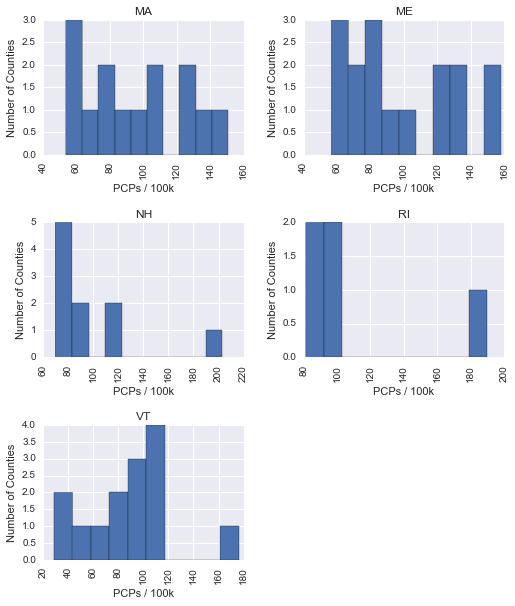

In [40]:
plots = ahrf_frame[ahrf_frame["StateNameAbbreviation"].isin(["RI","ME","NH","MA","VT"])].hist(column = "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",
                                                                                               by = "StateNameAbbreviation",figsize = (8,10),
                                                                                      normed=0)

map(lambda x: map(lambda y: (y.set_ylabel("Number of Counties"),y.set_xlabel("PCPs / 100k")),x), plots)

The above plots show the distribution of primary care physician density for each states with the highest average primary care physician density. In RI there seems to be exactly 1 county with 180 primary care physicians per 100K population.

[[(<matplotlib.text.Text at 0x1206b0dd0>,
   <matplotlib.text.Text at 0x1205dcd50>),
  (<matplotlib.text.Text at 0x120ea3750>,
   <matplotlib.text.Text at 0x120e8e7d0>)],
 [(<matplotlib.text.Text at 0x121449e50>,
   <matplotlib.text.Text at 0x121432ed0>),
  (<matplotlib.text.Text at 0x1214abf90>,
   <matplotlib.text.Text at 0x12149f050>)],
 [(<matplotlib.text.Text at 0x121537110>,
   <matplotlib.text.Text at 0x1215221d0>),
  (<matplotlib.text.Text at 0x121590dd0>,
   <matplotlib.text.Text at 0x12157be50>)]]

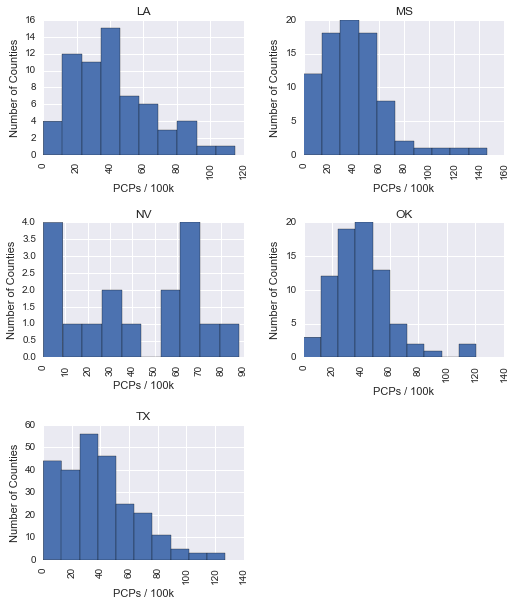

In [41]:
plots = ahrf_frame[ahrf_frame["StateNameAbbreviation"].isin(["LA","OK","NV","MS","TX"])].hist(column = "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",
                                                                                               by = "StateNameAbbreviation",figsize = (8,10),
                                                                                      normed=0)
map(lambda x: map(lambda y: (y.set_ylabel("Number of Counties"),y.set_xlabel("PCPs / 100k")),x), plots)

The above plots show the distribution of primary care physician density for states with the lowest average primary care density. Let us define the following helper function to plot the distribution of a variable over the counties of the given state.

In [42]:
def plot_state_counties(state_wise,state,variable_to_distribute,variables_to_display):
    """Plots the distribution of a given variable across the given sttate
    
    input: state_wise is a data frame containing the county level data
    input: state is the 2 character state abbreviations
    input: variable_to_distribute is the variable that you want to see across the state
    variables_to_display: Variables to display on hovering over each county
    
    output: Bokeh plotting object
    """
    from bokeh.sampledata.us_counties import data as counties
    counties = {
    code: county for code, county in counties.items() if county["state"] == state.lower()
    }
    county_xs = [county["lons"] for county in counties.values()]
    county_ys = [county["lats"] for county in counties.values()]
    
    if variable_to_distribute in variables_to_display:
        variables_to_display.remove(variable_to_distribute)

    colors = palettes.viridis(4)
    min_value = state_wise[variable_to_distribute].min()
    max_value = state_wise[variable_to_distribute].max()
    gran = (max_value - min_value) / float(len(colors))
    #print variable_to_distribute,state,min_value,max_value
    index_range = [min_value + x*gran for x in range(len(colors))]
    county_colors = []
    variable_dictionary = {}
    variable_dictionary["county_names"] = [county['name'] for county in counties.values()]
    variable_dictionary["x"] = county_xs
    variable_dictionary["y"] = county_ys
    variable_dictionary[re.sub("[^\w]","",variable_to_distribute)] = []
    for vd in variables_to_display:
        variable_dictionary[re.sub("[^\w]","",vd)] = []
    for county_id in counties:
        StateCountyID = str(county_id[0]).zfill(2) + str(county_id[1]).zfill(3)
        if StateCountyID in list(state_wise["Header-FIPSStandCtyCode"].values):
            temp_var = state_wise[state_wise["Header-FIPSStandCtyCode"] == StateCountyID][variable_to_distribute].values[0]
            if temp_var > 0.0:
                variable_dictionary[re.sub("[^\w]","",variable_to_distribute)].append(temp_var)
                for vd in variables_to_display:
                    variable_dictionary[re.sub("[^\w]","",vd)].append(round(float(state_wise[state_wise["Header-FIPSStandCtyCode"] == StateCountyID][vd].values),2))
                color_idx = list(temp_var - np.array(index_range)).index(min(x for x in list(temp_var - np.array(index_range)) if x >= 0))
                county_colors.append(colors[color_idx])
            else:
                variable_dictionary[re.sub("[^\w]","",variable_to_distribute)].append(0.0)
                county_colors.append("#A9A9A9")
                for vd in variables_to_display:
                    variable_dictionary[re.sub("[^\w]","",vd)].append(0.0)
        else:
            variable_dictionary[re.sub("[^\w]","",variable_to_distribute)].append(0.0)
            county_colors.append("#A9A9A9")
            for vd in variables_to_display:
                variable_dictionary[re.sub("[^\w]","",vd)].append(0.0)
        #print temp_var,counties[county_id]["name"]
    variable_dictionary["color"] = county_colors
    source = ColumnDataSource(data = variable_dictionary)
    TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

    mapper = LinearColorMapper(palette=colors, low=min_value, high=max_value)

    color_bar = ColorBar(color_mapper=mapper, location=(0, 0), orientation='horizontal', 
                     title = variable_to_distribute,ticker=FixedTicker(ticks=index_range))

    p = figure(title=variable_to_distribute + " for " + state, toolbar_location="left",tools=TOOLS,
        plot_width=1100, plot_height=700,x_axis_location=None, y_axis_location=None)

    p.patches('x', 'y', source=source, fill_alpha=0.7,fill_color='color',
        line_color="#884444", line_width=2)

    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    tool_tips = [("County ", "@county_names")]
    for key in variable_dictionary.keys():
        if key not in ["x","y","color","county_names"]:
            tool_tips.append((key,"@"+re.sub("[^\w]","",key) + "{1.11}"))
    hover.tooltips = tool_tips
    
    p.add_layout(color_bar, 'below')
    
    return p

Let us pick Maine from the top 5 states and Oklahoma from the bottom 5 states and look at the county wise distribution of primary care physicians. 

In [43]:
p = plot_state_counties(ahrf_frame[ahrf_frame["StateNameAbbreviation"] == "ME"],
                        "ME","Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",["UnemploymentRate,16+2014",
                                                                               "PerCapitaPersonalIncome2014",
                                                                               "%<65withoutHealthInsurance2014",
                                                                               "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"])
show(p)

In [44]:
p = plot_state_counties(ahrf_frame[ahrf_frame["StateNameAbbreviation"] == "OK"],
                        "OK","Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",["UnemploymentRate,16+2014",
                                                                               "PerCapitaPersonalIncome2014",
                                                                               "%<65withoutHealthInsurance2014"])
show(p)

### Medical Expenditures 
Earlier we saw that New Jersey accounted for a very high readmission rate (~19%), let us look at the distribution of the readmission rates across the state.

In [45]:
p = plot_state_counties(ahrf_frame[ahrf_frame["StateNameAbbreviation"] == "NJ"],
                        "NJ","MedcreBenefHospReadmissRateFeeforService2014",["ActualPerCapitaMedicareCostFeeforService2014",
                                                                             "TotStandardizedMedicareCostsFeeforService2014",
                                                                             "TotalActualMedicareCostsFeeforService2014",
                                                                             "StandardzdPerCapitaMedcrCostFeeforService2014"])
show(p) 

In [46]:
p = plot_state_counties(ahrf_frame[ahrf_frame["StateNameAbbreviation"] == "CO"],
                        "CO","MedcreBenefHospReadmissRateFeeforService2014",["ActualPerCapitaMedicareCostFeeforService2014",
                                                                                                "TotStandardizedMedicareCostsFeeforService2014",
                                                                                                "TotalActualMedicareCostsFeeforService2014",
                                                                                                "StandardzdPerCapitaMedcrCostFeeforService2014"])
show(p)

From the above county map of New Jersey, we see that there are multiple counties which account for the high readmissions rate, Hunterdon in the Northwest has a low readmissions rate and low Medicare costs. On the bottom plot of Colorado, a single county Jackson has a readmissions rate of 36%.
### Utilization
To analyze utilization at the county level, let us derive a quantity called mean utilization rate or expected utilization rate. We will use this metric to plot the distribution across the states of New Jersey and Colorado.

In [47]:
utilization_columns = ["DistHospBy00-39%UtilRateShortTermGeneralHospitals2013",
                       "DistHospBy40-59%UtilRateShortTermGeneralHospitals2013",
                       "DistHospBy60-79%UtilRateShortTermGeneralHospitals2013",
                       "DistHospBy80+%UtilRateShortTermGeneralHospitals2013",
                       "#ShortTermGeneralHosps2013"]
ahrf_frame["mean_utilization"] = map(lambda x: (0.2*x[0] + 0.5*x[1] + 0.7*x[2] + 0.9*x[3])/x[4] ,ahrf_frame[utilization_columns].values)

/Users/adityanagarajan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


In [48]:
p = plot_state_counties(ahrf_frame[ahrf_frame["StateNameAbbreviation"] == "NJ"],"NJ",
                        "mean_utilization",utilization_columns)
show(p)

As we have seen from the readmission rate the counties Cumberland, Essex and Hudson accounted for high readmission rates in the order of 20%. From the utilization plot we see that surprisingly hospitals in Hudson are not over utilized but Essex and Cumberland are over utilized with rates of 64% and 70% respectively.

In [49]:
p = plot_state_counties(ahrf_frame[ahrf_frame["StateNameAbbreviation"] == "CO"],"CO",
                        "mean_utilization",utilization_columns)
show(p)

The county of Jackson which accounted for 36% readmission rate does not have any hospitals, the county adjacent to it Routt has a relatively high mean utilization of 70%. As a general trend all counties next to counties without any hospitals (colored in grey) seem to have high utilizations. 
### Demographics
To analyze the demographic data at the county level, let us first sort the states on average percentage of people without health insurance and determine the top 5 and the bottom 5 states and plot the distribution of percentage of people without health insurance. 

In [50]:
state_means.sort_values(by = "%<65withoutHealthInsurance2014",ascending = 0)[:5][["StateNameAbbreviation",
                                                                               "%<65withoutHealthInsurance2014"]]

,StateNameAbbreviation,%<65withoutHealthInsurance2014
0,AK,24.20
43,TX,22.77
9,FL,19.73
36,OK,19.35
26,MT,19.14


In [51]:
state_means.sort_values(by = "%<65withoutHealthInsurance2014",ascending = 0)[-5:][["StateNameAbbreviation",
                                                                               "%<65withoutHealthInsurance2014"]]

,StateNameAbbreviation,%<65withoutHealthInsurance2014
39,RI,6.92
11,HI,6.68
46,VT,6.60
7,DC,5.90
19,MA,3.99


[[(<matplotlib.text.Text at 0x12031e6d0>,
   <matplotlib.text.Text at 0x12187a4d0>),
  (<matplotlib.text.Text at 0x121b1cdd0>,
   <matplotlib.text.Text at 0x121b08e50>)],
 [(<matplotlib.text.Text at 0x121b89350>,
   <matplotlib.text.Text at 0x121b763d0>),
  (<matplotlib.text.Text at 0x1201038d0>,
   <matplotlib.text.Text at 0x121c33950>)],
 [(<matplotlib.text.Text at 0x1203830d0>,
   <matplotlib.text.Text at 0x1200f8290>),
  (<matplotlib.text.Text at 0x121958610>,
   <matplotlib.text.Text at 0x121944690>)]]

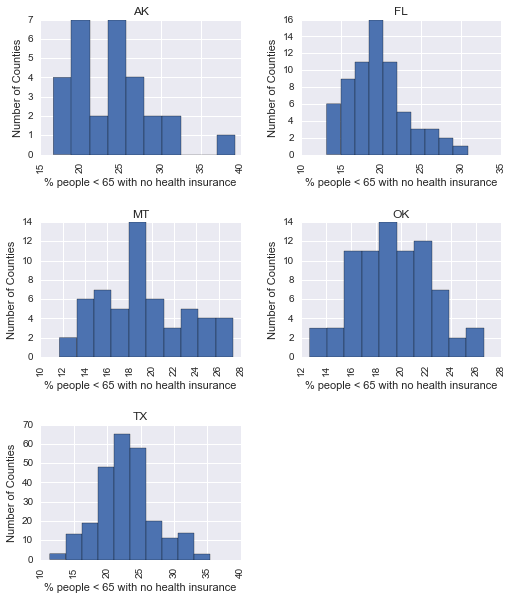

In [52]:
plots = ahrf_frame[ahrf_frame["StateNameAbbreviation"].isin(["AK","TX","FL","OK","MT"])].hist(column = "%<65withoutHealthInsurance2014",
                                                                                               by = "StateNameAbbreviation",figsize = (8,10),
                                                                                      normed=0)
map(lambda x: map(lambda y: (y.set_ylabel("Number of Counties"),y.set_xlabel("% people < 65 with no health insurance")),x), plots)

[[(<matplotlib.text.Text at 0x122418750>,
   <matplotlib.text.Text at 0x121613850>),
  (<matplotlib.text.Text at 0x1224908d0>,
   <matplotlib.text.Text at 0x12247a950>)],
 [(<matplotlib.text.Text at 0x122510a10>,
   <matplotlib.text.Text at 0x1224fba90>),
  (<matplotlib.text.Text at 0x1225746d0>,
   <matplotlib.text.Text at 0x12255f790>)],
 [(<matplotlib.text.Text at 0x1225f4c50>,
   <matplotlib.text.Text at 0x1225decd0>),
  (<matplotlib.text.Text at 0x122659550>,
   <matplotlib.text.Text at 0x1226445d0>)]]

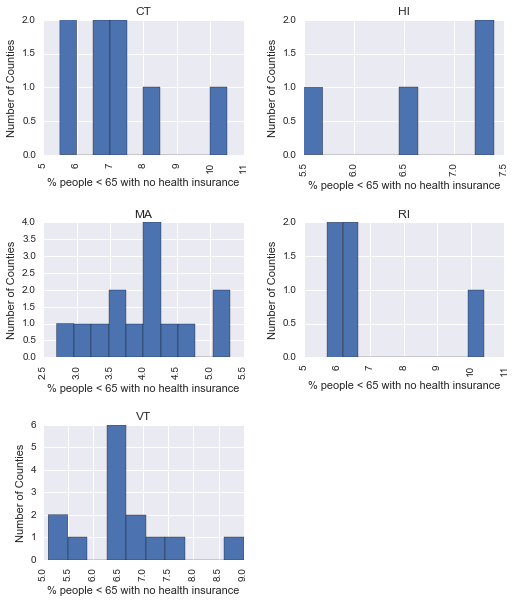

In [53]:
plots = ahrf_frame[ahrf_frame["StateNameAbbreviation"].isin(["CT","RI","HI","VT","MA"])].hist(column = "%<65withoutHealthInsurance2014",
                                                                                               by = "StateNameAbbreviation",figsize = (8,10),
                                                                                              normed = 0)

map(lambda x: map(lambda y: (y.set_ylabel("Number of Counties"),y.set_xlabel("% people < 65 with no health insurance")),x), plots)

In [54]:
p = plot_state_counties(ahrf_frame[ahrf_frame["StateNameAbbreviation"] == "TX"],"TX",
                        "%<65withoutHealthInsurance2014",["UnemploymentRate,16+2014",
                                                          "PerCapitaPersonalIncome2014",
                                                          "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"])
show(p)
print "State Means"
state_means[state_means["StateNameAbbreviation"] == "TX"]

State Means


,StateNameAbbreviation,PopulationEstimate2014,%<65withoutHealthInsurance2014,"UnemploymentRate,16+2014",PerCapitaPersonalIncome2014,"Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"
43,TX,106129.76,22.77,4.94,41720.87,38.13


In [55]:
p = plot_state_counties(ahrf_frame[ahrf_frame["StateNameAbbreviation"] == "MA"],"MA",
                        "%<65withoutHealthInsurance2014",["UnemploymentRate,16+2014",
                                                          "PerCapitaPersonalIncome2014",
                                                          "Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm",
                                                          "%<65withoutHealthInsurance2014"])
show(p)
state_means[state_means["StateNameAbbreviation"] == "MA"]

,StateNameAbbreviation,PopulationEstimate2014,%<65withoutHealthInsurance2014,"UnemploymentRate,16+2014",PerCapitaPersonalIncome2014,"Phys,PrimaryCare,PatientCareNon-Fed2014PopNorm"
19,MA,481814.86,3.99,6.15,57841.64,96.02


**Note**: Seems like Bokeh has inverted the cape in Massachusetts and Dukes and Nantucket are islands and not on the mainland. This is a bug in Bokeh. 
# Correlation Analysis
We perform [Pearson's Correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence) on select set of variables that we analyzed above. Pandas has a quick and easy way to to extract the correlation coefficients using the corr() function, and also ignores missing values.

In [56]:
ahrf_correlations = ahrf_frame[["PopulationEstimate2013",
                               "Phys,PrimaryCare,PatientCareNon-Fed2013",
                               "TotalActiveM.D.sNon-FederalNon-Fed2013",
                               "TotalActiveD.O.sNon-FederalNon-Fed2013",
                               "StandardzdPerCapitaMedcrCostFeeforService2013",
                               "%<65withoutHealthInsurance2013",
                               "UnemploymentRate,16+2013",
                               "PerCapitaPersonalIncome2013",
                                "PercentPersonsinPoverty2013",
                                "MedcreBenefHospReadmissRateFeeforService2013",
                                "ShortTermGeneralHospBeds2013",
                                "#ShortTermGeneralHosps2013",
                                "mean_utilization",
                                "ShortTermGenHospAdmissions2013"
                               ]].copy()

In [57]:
normalize_columns = ["Phys,PrimaryCare,PatientCareNon-Fed2013",
                     "TotalActiveM.D.sNon-FederalNon-Fed2013",
                     "TotalActiveD.O.sNon-FederalNon-Fed2013",
                     "ShortTermGenHospAdmissions2013",
                     "#ShortTermGeneralHosps2013",
                     "ShortTermGeneralHospBeds2013"]
ahrf_correlations = normalize_by_population(ahrf_correlations,normalize_columns)

In [58]:
ahrf_correlations = ahrf_correlations.drop(normalize_columns,axis=1)

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5]),
 <a list of 14 Text yticklabel objects>)

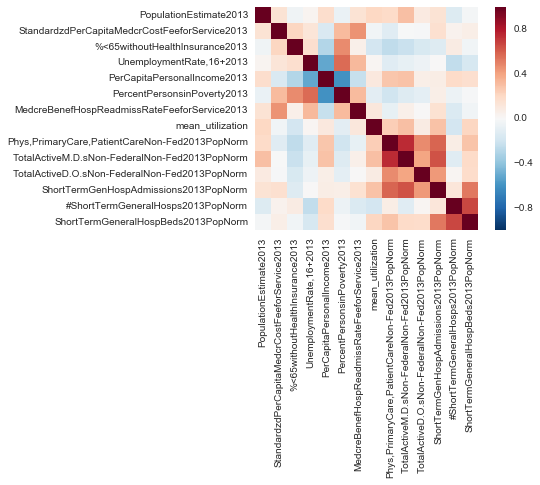

In [59]:
ahrf_correlations
cm = ahrf_correlations.corr()
sns.heatmap(cm,square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

From the above heat map, we can see some obvious and not so obvious correlations. The obvious ones are percentage of people in poverty is negatively correlated with per capita personal income and unemployment rate. The interesting ones are readmissions rate is correlated with per capita Medicare cost fee for service cost which suggests that if we decrease the readmissions rate we can bring the per-capita Medicare cost down. 

Per capita personal income is negatively correlated with percentage of people without health insurance suggesting that as incomes go up people generally buy health insurance. 

Mean utilization is correlated with hospital admissions and total active M.Ds normalized by 100k people. 


# Conclusion
We have successfully developed and verified an API for mining and extracting data from the AHRF ascii file, and we looked into a small subset of variables in that file. Visualization tools are developed in this I-Python notebook which is capable of plotting a given variable at the State level or the county level along with displaying variables by hovering over the state or county. We found some interesting correlations such as readmissions rate and per capita Medicare costs. 

Further analysis can be done using the visualization tools and ideas presented in this notebook. The API can also be further optimized to read the ascii file and generate the data frame faster.

**A Note on Missing values:**There are several missing values for some counties and variables. While calculating the statistics across these variables Pandas ignores the rows with missing values and thus we do not deal with them explicitly here.